# QAL-BP: An Augmented Lagrangian Quantum Approach for Bin Packing

This notebook demonstrates the pipeline of solving the Bin Packing problem using QAL-BP.

Consider that when using Quantum Annealing results may stongly vary from one run to another, influencing also the benchmark analysis.

**IMPORTANT: before running this notebook create a config.py file with the variable dimod.token="your_token" in the same folder of the notebook**

In [1]:
!git clone https://github.com/Lorenz92/QAL-BP.git
%cd QAL-BP/
!ls

Cloning into 'QAL-BP'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 35 (delta 11), reused 31 (delta 7), pack-reused 0
Receiving objects: 100% (35/35), 284.18 KiB | 4.00 MiB/s, done.
Resolving deltas: 100% (11/11), done.
/content/QAL-BP
QAL_BP.ipynb  README.md  results  utils.py


## Install and Import Dependencies

In [2]:
# If this notebook is running on Windows OS, change apt with tlmgr
!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal dvisvgm fonts-adf-accanthis fonts-adf-berenis fonts-adf-gillius
  fonts-adf-universalis fonts-cabin fonts-cantarell fonts-comfortaa fonts-croscore
  fonts-crosextra-caladea fonts-crosextra-carlito fonts-dejavu-core fonts-dejavu-extra
  fonts-droid-fallback fonts-ebgaramond fonts-ebgaramond-extra fonts-font-awesome
  fonts-freefont-otf fonts-freefont-ttf fonts-gfs-artemisia fonts-gfs-complutum fonts-gfs-didot
  fonts-gfs-neohellenic fonts-gfs-olga fonts-gfs-solomos fonts-go fonts-junicode fonts-lato
  fonts-linuxlibertine fonts-lmodern fonts-lobster fonts-lobstertwo fonts-noto-color-emoji
  fonts-noto-core fonts-noto-mono fonts-oflb-asana-math fonts-open-sans fonts-roboto-unhinted
  fonts-sil-charis fonts-sil-gentium fonts-sil-gentium-basic fonts-sil-gentiumplus
  fonts-sil-gentiumplus-compact fonts-stix fonts-texgyre fo

In [3]:
!pip install gurobipy pyqubo dimod dwave-system SciencePlots

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 60.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.4/18.4 MB 73.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.2/137.2 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 87.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 94.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 100.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 90.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.8/395.8 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [4]:
! pip install dwave-inspector
! pip install dwave-inspectorapp --extra-index=https://pypi.dwavesys.com/simple

Looking in indexes: https://pypi.org/simple, https://pypi.dwavesys.com/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 6.3 MB/s eta 0:00:00


In [5]:
import pandas as pd
from utils import *

json_path = './solutions/'
num_reads = 100

%matplotlib inline

%load_ext autoreload
%autoreload 2

# The Bin Packing Problem

The bin packing problem (BPP) is a classic optimization task that involves packing objects of different sizes into containers, or bins, with a limited capacity.
The goal is to minimize the number of bins needed to pack all the objects.
A mathematical formulation of the bin packing problem can be expressed as follows: given a set of $n$ items of given integer size (or weight) $w_j \ (j = 1, \ldots , n)$ the goal is to pack them
 into the minimum number of identical bins of integer capacity $C$.

Let $m$ be any upper bound on the solution value and let introduce $y_i, x_{ij}$ two sets of binary variables such that:
$y_i (i = 1, \ldots, m)$ takes the value $1$ if and only if bin $i$ is used in the solution
and $x_{ij} (i = 1, \ldots, m; j = 1, \ldots, n)$ takes the value $1$ if and only if item $j$ is packed into bin $i$.
A commonly adopted Integer Linear Programming (ILP) problem formulation is given by *S. Martello and P. Toth, in “Knapsack Problems: Algorithms and Computer Implementation”* and is the following:

\begin{align}
  \underset{x, y}{\operatorname{argmin}} \ & \sum_{i=1}^m y_i \\
  \text{s.t. }
  & \sum_{i=1}^m x_{ij} = 1 & \forall j = 1, \dots, n \\
  & \sum_{j=1}^n w_j x_{ij} \leq C y_i & \forall i = 1, \dots, m \\
  & x_{ij} \in \{0, 1\} & \forall i = 1, \dots, m, \ \forall j = 1, \dots, n  \\
  & y_{i} \in \{0, 1\} & \forall i = 1, \dots, m
\end{align}


## Bin Packing Problem instances generation

In the following experiments we consider a set of 40 instances with number of items ranging from 3 to 10 and a fixed bin capacity of 10. The different instances are randomly generated using 5 different seeds.

In [6]:
# Instances used for QA and SA
seeds = [23, 42, 123, 90, 510]

instances = {
    'bpp_3_10': {
        'num_items' : 3,
        'bin_capacity' : 10,
    },
    'bpp_4_10': {
        'num_items' : 4,
        'bin_capacity' : 10,
    },
    'bpp_5_10': {
        'num_items' : 5,
        'bin_capacity' : 10,
    },
    'bpp_6_10': {
        'num_items' : 6,
        'bin_capacity' : 10,
    },
    'bpp_7_10': {
        'num_items' : 7,
        'bin_capacity' : 10,
    },
    'bpp_8_10': {
        'num_items' : 8,
        'bin_capacity' : 10,
    },
    'bpp_9_10': {
        'num_items' : 9,
        'bin_capacity' : 10,
    },
    'bpp_10_10': {
        'num_items' : 10,
        'bin_capacity' : 10,
    }
}

The following cell is used to generates the parameters $A$ and $B$ of the Pseudo Polynomial model.

In [7]:
As = [.1,.3,.5,1,3,5,10,25,50,100,1000]
Bs = [.01,.05,.1,.5,1,2,5,10]

PP_pens=[]
for a in As:
  for b in Bs:
    pen = {}
    pen['A'] = a
    pen['B'] = b
    PP_pens.append(pen)

print(f'Number of parameters values combination: {len(PP_pens)}')

Number of parameters values combination: 88


Generation of the instances dataframe.

In [8]:
df_seeds = pd.DataFrame()

for seed in seeds:
  df_seed = instance_generator(instances, seed)
  df_seeds = pd.concat([df_seeds, df_seed], axis = 0, ignore_index=True)

df = df_seeds.copy()
df.head()

,instance_name,seed,c,w,n,wmin,wmax,lb
0,bpp_3_10,23,10,"[4, 8, 6]",3,4,8,2
1,bpp_4_10,23,10,"[7, 5, 4, 7]",4,4,7,3
2,bpp_5_10,23,10,"[4, 4, 7, 7, 9]",5,4,9,4
3,bpp_6_10,23,10,"[6, 5, 5, 5, 4, 8]",6,4,8,4
4,bpp_7_10,23,10,"[8, 6, 8, 6, 8, 6, 6]",7,6,8,5


# ILP Formulation of BPP solved via Branch-and-Bound by Gurobi

In this section, we solve the ILP formulation given above via the Gurobi optimizer, as a representative for state-of-the-art solution that relies on the branch-and-bound technique to efficiently find the optimal solution.

In [9]:
gurobi_df = gurobi_solve(df, num_reads)
gurobi_df.to_csv('./gurobi_df_40_instances.csv',float_format='%.6f')

df_total = pd.concat([df, gurobi_df], axis = 1)
display(df_total)

Restricted license - for non-production use only - expires 2024-10-28


,instance_name,seed,c,w,n,wmin,wmax,lb,gurobi_n_bins,gurobi_bin_for_item,gurobi_runtime,bin_filling
0,bpp_3_10,23,10,"[4, 8, 6]",3,4,8,2,2.0,"[2, 0, 2]",667.19,"{2: 10, 0: 8}"
1,bpp_4_10,23,10,"[7, 5, 4, 7]",4,4,7,3,3.0,"[1, 3, 3, 2]",886.16,"{1: 7, 3: 9, 2: 7}"
2,bpp_5_10,23,10,"[4, 4, 7, 7, 9]",5,4,9,4,4.0,"[0, 0, 4, 2, 1]",922.52,"{0: 8, 4: 7, 2: 7, 1: 9}"
3,bpp_6_10,23,10,"[6, 5, 5, 5, 4, 8]",6,4,8,4,4.0,"[2, 4, 4, 1, 1, 0]",748.35,"{2: 6, 4: 10, 1: 9, 0: 8}"
4,bpp_7_10,23,10,"[8, 6, 8, 6, 8, 6, 6]",7,6,8,5,7.0,"[0, 2, 6, 4, 3, 5, 1]",645.84,"{0: 8, 2: 6, 6: 8, 4: 6, 3: 8, 5: 6, 1: 6}"
5,bpp_8_10,23,10,"[4, 5, 6, 4, 5, 4, 6, 4]",8,4,6,4,4.0,"[0, 1, 0, 2, 1, 2, 6, 6]",4187.69,"{0: 10, 1: 10, 2: 8, 6: 10}"
6,bpp_9_10,23,10,"[7, 5, 8, 4, 7, 4, 8, 5, 4]",9,4,8,6,7.0,"[2, 7, 6, 1, 5, 1, 0, 8, 8]",1218.49,"{2: 7, 7: 5, 6: 8, 1: 8, 5: 7, 0: 8, 8: 9}"
7,bpp_10_10,23,10,"[5, 7, 5, 7, 9, 9, 4, 9, 6, 4]",10,4,9,7,8.0,"[5, 0, 8, 7, 6, 9, 8, 2, 4, 4]",8671.88,"{5: 5, 0: 7, 8: 9, 7: 7, 6: 9, 9: 9, 2: 9, 4: 10}"
8,bpp_3_10,42,10,"[4, 8, 7]",3,4,8,2,3.0,"[2, 0, 1]",2162.04,"{2: 4, 0: 8, 1: 7}"
9,bpp_4_10,42,10,"[6, 6, 9, 4]",4,4,9,3,3.0,"[2, 0, 1, 0]",2001.67,"{2: 6, 0: 10, 1: 9}"


# Pseudo Polynomial Formulation

The first QUBO formulation of the Bin Packing Problem appeared in *Mapping NP-hard and NP-complete optimisation problems to
Quadratic Unconstrained Binary Optimisation problems, by Bas Lodewijks* in 2019. In this publication, the author a QUBO formulation for the bin acking problem, such as the following:

given the variables $x_{ij}, i \in \{1, .., N\}, j \in \{1, .., K\}$, where $x_{ij} = 1$ if weight $j$ is placed in bin $i$, variables $y_i, i \in \{1, .., N\}$, where $y_i = 1$ if bin $i$ is not empty,
and variables $z_{ik}, i \in \{1, .., N\}, k \in \{1, .., C\}$, where $z_{ik} = 1$ if bin $i$ has been filled up to level $k$, that is, when the sum of the weights of the objects in bin $i$ equals exactly $k$.
The Hamiltonian can be written as:
\begin{align}
    H_A = & A\sum_{i=1}^{N} \left( x_i - \sum_{k=1}^C z_{ik} \right)^2 \\
    + & A\sum_{j=1}^{K} \left( 1 - \sum_{i=1}^N x_{ij} \right)^2 \\
    + & A\sum_{i=1}^{N} \left( \sum_{k=1}^{C}kz_{ik} - \sum_{j=1}^K w_j x_{ij} \right)^2 \\
    + & A\sum_{i=1}^{N} \left( 1 - x_i \right) \sum_{j=1}^K x_{ij} \\
    H_B = & B\sum_{i=1}^N x_{i}
\end{align}

## Pseudo Polynomial model solved by Simulated Annealing

In the next cell we solve the QUBO formulation given by Lodewijks using SA.

In [ ]:
models = ['PP']
solvers = ['SA']

pp_penalties = None
al_penalties= None
QUBOs_df = pd.DataFrame()
PP_test_pens = copy.deepcopy(PP_pens)


for i in tqdm(range(len(PP_test_pens))):
  pp_penalties = PP_test_pens[i]
  QUBO_df = solve_QUBOs(df, models, solvers, num_reads, al_penalties, pp_penalties, al_gamma_term=True, save_to_json=False, path=json_path)
  QUBOs_df = pd.concat([QUBOs_df, QUBO_df], axis = 0)

QUBOs_df.head()

QUBOs_df.to_csv('./final_PP_grid.csv',float_format='%.6f')


# Aumented Lagrangian QUBO Formulation

In this work, we presented QAL-BP (*Quantum Augmented Lagrangian method for Bin Packing*), a novel QUBO formulation for the BPP based on the Augmented Lagrangian method.

The Quantum Augmented Lagrangian method for Bin Packing (QAL-BP) embeds the constraints using the augmented Lagrangian method as follows:
\begin{align}
    \text{argmin}_{x, y} \ & \delta\sum_{i=1}^m y_i \\
    & + \sum_{i=1}^{m} \lambda_i \left( \sum_{j=1}^n w_j x_{ij} - c_i y_i \right) \\
    & + \sum_{i=1}^{m} \rho_i \left( \sum_{j=1}^n w_j x_{ij} - c_i y_i \right)^2 \\
    & + \theta \sum_{j=1}^n \left(\sum_{i=1}^m x_{ij}-1\right)^2 \\
    & +  \gamma \sum_{i=1}^m \left(1 - y_i \right)\sum_{j=1}^n x_{ij} \\
    \text{s.t. }
    x_{ij}& \in \{0, 1\} \qquad \forall i = 1 \dots, m, \forall j = 1 \dots, n \nonumber \\ \nonumber
    y_{i} & \in \{0, 1\} \qquad \forall i = 1 \dots, m \\
    \delta, &\lambda, \rho, \theta, \gamma \ge 0 \nonumber
\end{align}

QUBO penalties are estimated according to **QAL-BP: An Augmented Lagrangian Quantum Approach for Bin Packing Problem** by *Lorenzo Cellini, Antonio Macaluso, and Michele Lombardi*.

In the next two cells the QAL-BP is solved respectively by *Simulated Annealing (SA)* and *Quantum Annealing (QA)*.

### QAL-BP solved by Simulated Annealing

In [32]:
models = ['AL']
solvers = ['SA']

pp_penalties = None
al_penalties = None

df_final_SA = df_total.copy()
QUBO_df = solve_QUBOs(df, models, solvers, num_reads, al_penalties, pp_penalties, al_gamma_term=True, save_to_json=False, path=json_path)
df_final_SA = pd.concat([df_final_SA, QUBO_df], axis = 1)

df_final_SA.to_csv(f'./SA_nr{num_reads}.csv',float_format='%.6f')
df_final_SA.head()

Set penalty as: Default for AL and Default for PP


,instance_name,seed,c,w,n,wmin,wmax,lb,gurobi_n_bins,gurobi_bin_for_item,...,AL_SA_real_weights_sum,AL_SA_placed_weights_sum,AL_SA_used_items,AL_SA_feasible,AL_SA_reason,AL_SA_penalties_dict_delta,AL_SA_penalties_dict_theta,AL_SA_penalties_dict_lmbd,AL_SA_penalties_dict_rho,AL_SA_penalties_dict_gamma
0,bpp_3_10,23,10,"[4, 8, 6]",3,4,8,2,2.0,"[2, 0, 2]",...,18,18,"[0, 2, 1]",True,[],0.15,2,0.1389,0.0278,1
1,bpp_4_10,23,10,"[7, 5, 4, 7]",4,4,7,3,3.0,"[1, 3, 3, 2]",...,23,23,"[3, 0, 1, 2]",True,[],0.15,2,0.1389,0.0278,1
2,bpp_5_10,23,10,"[4, 4, 7, 7, 9]",5,4,9,4,4.0,"[0, 0, 4, 2, 1]",...,31,31,"[0, 1, 3, 2, 4]",True,[],0.15,2,0.1389,0.0278,1
3,bpp_6_10,23,10,"[6, 5, 5, 5, 4, 8]",6,4,8,4,4.0,"[2, 4, 4, 1, 1, 0]",...,33,33,"[5, 1, 3, 0, 2, 4]",True,[],0.15,2,0.1389,0.0278,1
4,bpp_7_10,23,10,"[8, 6, 8, 6, 8, 6, 6]",7,6,8,5,7.0,"[0, 2, 6, 4, 3, 5, 1]",...,48,48,"[1, 5, 0, 2, 3, 6, 4]",True,[],0.15,2,0.0758,0.0152,1


### QAL-BP solved by Quantum Annealing

In [112]:
### Testng cell

models = ['AL']
solvers = ['QA']

pp_penalties = None
al_penalties = None

df_final_QA = df_total.copy()
QUBO_df = solve_QUBOs(df.loc[:0,:], models, solvers, num_reads, al_penalties, pp_penalties, al_gamma_term=True, save_to_json=True, path=json_path)
df_final_QA = pd.concat([df_final_QA, QUBO_df], axis = 1)

df_final_QA.to_csv(f'./QA_nr{num_reads}.csv',float_format='%.6f')
df_final_QA.head(7)

Set penalty as: Default for AL and Default for PP


,instance_name,seed,c,w,n,wmin,wmax,lb,gurobi_n_bins,gurobi_bin_for_item,...,AL_QA_runtime_metrics_qpu_readout_time_per_sample,AL_QA_runtime_metrics_qpu_access_time,AL_QA_runtime_metrics_qpu_access_overhead_time,AL_QA_runtime_metrics_qpu_programming_time,AL_QA_runtime_metrics_qpu_delay_time_per_sample,AL_QA_runtime_metrics_total_post_processing_time,AL_QA_runtime_metrics_post_processing_overhead_time,AL_QA_cbf,AL_QA_logiqu,AL_QA_physiqu
0,bpp_3_10,23,10,"[4, 8, 6]",3,4,8,2,2.0,"[2, 0, 2]",...,101.04,29921.57,418.43,15763.57,20.54,218.0,218.0,0.0,12.0,15.0
1,bpp_4_10,23,10,"[7, 5, 4, 7]",4,4,7,3,3.0,"[1, 3, 3, 2]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,bpp_5_10,23,10,"[4, 4, 7, 7, 9]",5,4,9,4,4.0,"[0, 0, 4, 2, 1]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,bpp_6_10,23,10,"[6, 5, 5, 5, 4, 8]",6,4,8,4,4.0,"[2, 4, 4, 1, 1, 0]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,bpp_7_10,23,10,"[8, 6, 8, 6, 8, 6, 6]",7,6,8,5,7.0,"[0, 2, 6, 4, 3, 5, 1]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,bpp_8_10,23,10,"[4, 5, 6, 4, 5, 4, 6, 4]",8,4,6,4,4.0,"[0, 1, 0, 2, 1, 2, 6, 6]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,bpp_9_10,23,10,"[7, 5, 8, 4, 7, 4, 8, 5, 4]",9,4,8,6,7.0,"[2, 7, 6, 1, 5, 1, 0, 8, 8]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_final_QA.loc[1,:]

instance_name                                                                                   bpp_4_10
seed                                                                                                  23
c                                                                                                     10
w                                                                                           [7, 5, 4, 7]
n                                                                                                      4
wmin                                                                                                   4
wmax                                                                                                   7
lb                                                                                                     3
gurobi_n_bins                                                                                        3.0
gurobi_bin_for_item                                    

In [ ]:
# Python program to read
# json file

import json

# Opening JSON file
f = open('./solutions/bpp_3_10_1698396247.json')

# returns JSON object as
# a dictionary
data = json.load(f)
print(data)

# Closing file
f.close()

{'type': 'SampleSet', 'version': {'sampleset_schema': '3.2.0'}, 'num_variables': 12, 'num_rows': 40, 'sample_data': {'type': 'array', 'data': [[2693], [1578], [2882], [3240], [3408], [1557], [3857], [3682], [3850], [3745], [3724], [3668], [2819], [3352], [2756], [1564], [1571], [2945], [3184], [3464], [3920], [3233], [1634], [3808], [3882], [3924], [2817], [1569], [3753], [3669], [2240], [3859], [1565], [3633], [3696], [2432], [2883], [1066], [3457], [3973]], 'data_type': 'uint32', 'shape': [40, 1], 'use_bytes': False}, 'sample_type': 'int8', 'sample_packed': True, 'vectors': {'energy': {'type': 'array', 'data': [0.13339999999999996, 0.1333999999999982, 0.1333999999999982, 0.1333999999999982, 0.13339999999999907, 0.13339999999999996, 0.3399999999999994, 0.3399999999999981, 0.3399999999999981, 0.3399999999999985, 0.3399999999999981, 0.33999999999999897, 0.5781999999999989, 0.5781999999999989, 0.5782000000000007, 0.5781999999999989, 0.5781999999999989, 1.4678, 1.467799999999999, 1.467799

In [ ]:
import dimod
s = dimod.SampleSet.from_serializable(data)


In [ ]:
from utils import *
best_sample = s.first
sampleset = s
weights = df.loc[7,'w']
c = 10
for datum in s.data(fields=['sample', 'chain_break_fraction']):
  # min_eigenvalue = best_sample.energy
  yi, xij = compute_used_bins(datum)

  # eigenval_prob = compute_eigenval_prob(min_eigenvalue, sampleset)
  assignment, used_items = compute_assignment(datum, weights)
  real_weights_sum = sum(weights)
  placed_weights_sum = sum(assignment.values())

  feasible, reason = check_feasibility(len(yi), len(xij), assignment, real_weights_sum, placed_weights_sum, used_items, c)
  print(datum.chain_break_fraction, feasible, reason)

In [ ]:
s.info

{'timing': {'qpu_sampling_time': 14330.0,
  'qpu_anneal_time_per_sample': 20.0,
  'qpu_readout_time_per_sample': 102.76,
  'qpu_access_time': 30090.37,
  'qpu_access_overhead_time': 1881.63,
  'qpu_programming_time': 15760.37,
  'qpu_delay_time_per_sample': 20.54,
  'total_post_processing_time': 989.0,
  'post_processing_overhead_time': 989.0},
 'problem_id': 'fb9da1c4-459b-4898-a8d9-d96128c44e5c',
 'embedding_context': {'embedding': {'x[2][0]': [4860, 265],
   'x[2][1]': [4845],
   'x[1][0]': [4890],
   'y[1]': [191],
   'x[1][1]': [4995, 250],
   'x[0][1]': [280],
   'x[1][2]': [205, 206],
   'y[2]': [190],
   'x[2][2]': [4830],
   'y[0]': [4936],
   'x[0][2]': [295, 4980],
   'x[0][0]': [221, 4966]},
  'chain_break_method': 'majority_vote',
  'embedding_parameters': {},
  'chain_strength': 2.7261296307388463}}

In [ ]:
embedding = s.info['embedding_context']['embedding']
print(f"Number of logical variables: {len(embedding.keys())}")
print(f"Number of physical qubits used in embedding: {sum(len(chain) for chain in embedding.values())}")

Number of logical variables: 12
Number of physical qubits used in embedding: 17


In [14]:
models = ['AL']
solvers = ['QA']

pp_penalties = None
al_penalties = None

df_final_QA = df_total.copy()
QUBO_df = solve_QUBOs(df, models, solvers, num_reads, al_penalties, pp_penalties, al_gamma_term=True, save_to_json=True, path=json_path)
df_final_QA = pd.concat([df_final_QA, QUBO_df], axis = 1)

df_final_QA.to_csv(f'./QA_nr{num_reads}.csv',float_format='%.6f')
df_final_QA.head()

Set penalty as: Default for AL and Default for PP


,instance_name,seed,c,w,n,wmin,wmax,lb,gurobi_n_bins,gurobi_bin_for_item,...,AL_QA_penalties_dict_gamma,AL_QA_runtime_metrics_qpu_sampling_time,AL_QA_runtime_metrics_qpu_anneal_time_per_sample,AL_QA_runtime_metrics_qpu_readout_time_per_sample,AL_QA_runtime_metrics_qpu_access_time,AL_QA_runtime_metrics_qpu_access_overhead_time,AL_QA_runtime_metrics_qpu_programming_time,AL_QA_runtime_metrics_qpu_delay_time_per_sample,AL_QA_runtime_metrics_total_post_processing_time,AL_QA_runtime_metrics_post_processing_overhead_time
0,bpp_3_10,23,10,"[4, 8, 6]",3,4,8,2,2.0,"[2, 0, 2]",...,1,11538.0,20.0,74.84,27296.77,2305.23,15758.77,20.54,427.0,427.0
1,bpp_4_10,23,10,"[7, 5, 4, 7]",4,4,7,3,3.0,"[1, 3, 3, 2]",...,1,13376.0,20.0,93.22,29135.57,3144.43,15759.57,20.54,1876.0,1876.0
2,bpp_5_10,23,10,"[4, 4, 7, 7, 9]",5,4,9,4,4.0,"[0, 0, 4, 2, 1]",...,1,17962.0,20.0,139.08,33721.17,3222.83,15759.17,20.54,1958.0,1958.0
3,bpp_6_10,23,10,"[6, 5, 5, 5, 4, 8]",6,4,8,4,4.0,"[2, 4, 4, 1, 1, 0]",...,1,12836.0,20.0,87.82,28594.77,905.23,15758.77,20.54,843.0,843.0
4,bpp_7_10,23,10,"[8, 6, 8, 6, 8, 6, 6]",7,6,8,5,7.0,"[0, 2, 6, 4, 3, 5, 1]",...,1,17028.0,20.0,129.74,32788.37,1181.63,15760.37,20.54,2032.0,2032.0


### QAL-BP solved by enumeration (exact method)

**NOTE: be aware that it may take a lot of time and RAM resources to complete**

Indeed we selected the only two smallest instance classes that is capable to solve in a reasonable amount of time.

In [ ]:
models = ['AL']
solvers = ['Ex']

pp_penalties = None
al_penalties = None

df_exact = df[df['instance_name'].isin(['bpp_3_10','bpp_4_10'])]

df_final_Ex = df_total.copy()
QUBO_df = solve_QUBOs(df, models, solvers, num_reads, al_penalties, pp_penalties, al_gamma_term=True, save_to_json=False, path=json_path)
QUBO_df.index = list(df_exact.index)
df_final_Ex = pd.concat([df_final_Ex, QUBO_df], axis = 1)

display(df_final_Ex)

df_final_Ex.to_csv('./final_Ex.csv',float_format='%.6f')

# Model evaluation

In [33]:
# Read the previously saved results

df_final_Ex = pd.read_csv('./results/AL/final_Ex.csv',index_col=0)
df_final_SA = pd.read_csv(f'./results/AL/SA_nr{num_reads}.csv',index_col=0)
# df_final_QA = pd.read_csv(f'./results/AL/QA_nr{num_reads}.csv',index_col=0)

## Solutions

What follows is a comparison of the number of bins in solutions obtained by different solvers.

The graphs compares the number of bins in solutions generated by Gurobi, Simulated Annealing (SA), and
Quantum Annealing (QA) solvers for the given set of instances.

In [37]:
df_final_SA['gurobi_n_bins'] = df_final_SA['gurobi_n_bins'].astype(int)
df_final_SA['AL_SA_n_bins'] = df_final_SA['AL_SA_yi'].apply(lambda x:  len(x.strip("'][").replace("'",'').split(', ')))
df_num_bins_SA = df_final_SA[['instance_name','seed', 'gurobi_n_bins', 'AL_SA_n_bins']]

df_final_QA['AL_QA_n_bins'] = df_final_QA['AL_QA_yi'].apply(lambda x:  len(x))#len(x.strip("'][").replace("'",'').split(', ')))
df_num_bins_QA = df_final_QA[['instance_name','seed','AL_QA_n_bins']]

df_num_bins = pd.concat([df_num_bins_SA, df_num_bins_QA], axis = 1)
df_num_bins = df_num_bins.loc[:,~df_num_bins.columns.duplicated()]

df_num_bins.head()

,instance_name,seed,gurobi_n_bins,AL_SA_n_bins,AL_QA_n_bins
0,bpp_3_10,23,2,2,2
1,bpp_4_10,23,3,3,3
2,bpp_5_10,23,4,4,4
3,bpp_6_10,23,4,4,5
4,bpp_7_10,23,7,7,6


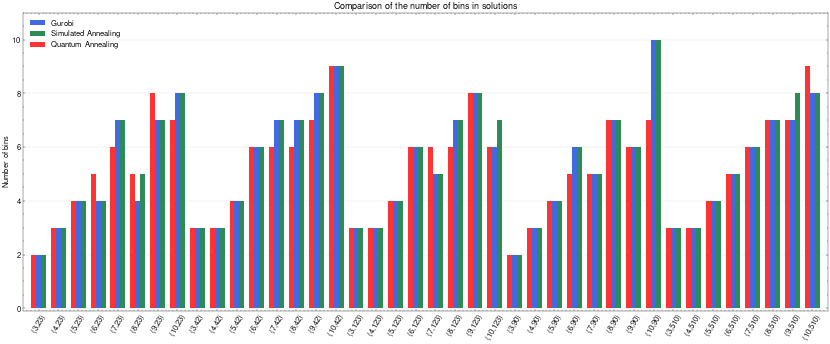

In [38]:
plot_num_bins(df_num_bins)

## Complexity plot

The following cell generate a plot illustrating the model complexity with respect to the number of items and bin capacity.

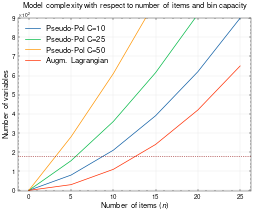

In [ ]:
plot_complexity()

## Runtime

The following cells create a plot to illustrate the runtime performance of the QAL-BPP model for various problem instances. It compares the runtime results for different solvers,
including Gurobi, Simulated Annealing (SA) with Augmented Lagrangian (AL) and Quantum Annealing (QA) with Augmented Lagrangian (AL).


In [23]:
df_mean_std_runtime_QA = df_final_QA2.groupby(['instance_name', 'n'], sort=False)['gurobi_runtime','AL_QA_runtime'].agg(['mean', 'std'])
df_mean_std_runtime_QA.columns = df_mean_std_runtime_QA.columns.map('_'.join)
display(df_mean_std_runtime_QA)

<ipython-input-23-58311092461a>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_mean_std_runtime_QA = df_final_QA2.groupby(['instance_name', 'n'], sort=False)['gurobi_runtime','AL_QA_runtime'].agg(['mean', 'std'])


,,gurobi_runtime_mean,gurobi_runtime_std,AL_QA_runtime_mean,AL_QA_runtime_std
instance_name,n,,,,
bpp_3_10,3,859.828,737.543108,10752.4,1228.311361
bpp_4_10,4,933.112,618.786480,12906.4,2379.780410
bpp_5_10,5,1147.358,670.403754,14088.4,3670.345597
bpp_6_10,6,1174.930,1181.917142,13554.0,3011.709481
bpp_7_10,7,1109.698,642.949574,14093.2,2686.285018
bpp_8_10,8,6554.386,10685.780163,13518.8,3144.638167
bpp_9_10,9,2502.732,2524.419700,16772.0,1669.971257
bpp_10_10,10,4661.672,2823.182528,18186.8,2597.528672


In [39]:
df_mean_std_runtime_QA = df_final_QA.groupby(['instance_name', 'n'], sort=False)['gurobi_runtime','AL_QA_runtime'].agg(['mean', 'std'])
df_mean_std_runtime_QA.columns = df_mean_std_runtime_QA.columns.map('_'.join)
display(df_mean_std_runtime_QA)

df_mean_std_runtime_SA = df_final_SA.groupby(['instance_name', 'n'], sort=False)['gurobi_runtime','AL_SA_runtime'].agg(['mean', 'std'])
df_mean_std_runtime_SA.columns = df_mean_std_runtime_SA.columns.map('_'.join)
display(df_mean_std_runtime_SA)

df_mean_std_runtime_Ex = df_final_Ex.groupby(['instance_name', 'n'], sort=False)['gurobi_runtime','AL_Ex_runtime'].agg(['mean', 'std'])
df_mean_std_runtime_Ex.columns = df_mean_std_runtime_Ex.columns.map('_'.join)
display(df_mean_std_runtime_Ex)

df_mean_std_runtime = pd.concat([df_mean_std_runtime_SA, df_mean_std_runtime_QA, df_mean_std_runtime_Ex], axis = 1)
df_mean_std_runtime = df_mean_std_runtime.loc[:,~df_mean_std_runtime.columns.duplicated()].reset_index()
display(df_mean_std_runtime)

<ipython-input-39-04325199534e>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_mean_std_runtime_QA = df_final_QA.groupby(['instance_name', 'n'], sort=False)['gurobi_runtime','AL_QA_runtime'].agg(['mean', 'std'])


,,gurobi_runtime_mean,gurobi_runtime_std,AL_QA_runtime_mean,AL_QA_runtime_std
instance_name,n,,,,
bpp_3_10,3,859.828,737.543108,10752.4,1228.311361
bpp_4_10,4,933.112,618.786480,12906.4,2379.780410
bpp_5_10,5,1147.358,670.403754,14088.4,3670.345597
bpp_6_10,6,1174.930,1181.917142,13554.0,3011.709481
bpp_7_10,7,1109.698,642.949574,14093.2,2686.285018
bpp_8_10,8,6554.386,10685.780163,13518.8,3144.638167
bpp_9_10,9,2502.732,2524.419700,16772.0,1669.971257
bpp_10_10,10,4661.672,2823.182528,18186.8,2597.528672


<ipython-input-39-04325199534e>:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_mean_std_runtime_SA = df_final_SA.groupby(['instance_name', 'n'], sort=False)['gurobi_runtime','AL_SA_runtime'].agg(['mean', 'std'])


,,gurobi_runtime_mean,gurobi_runtime_std,AL_SA_runtime_mean,AL_SA_runtime_std
instance_name,n,,,,
bpp_3_10,3,859.828,737.543108,278.872967,72.867205
bpp_4_10,4,933.112,618.786480,490.231514,239.537498
bpp_5_10,5,1147.358,670.403754,644.628048,176.106171
bpp_6_10,6,1174.930,1181.917142,882.030487,246.192500
bpp_7_10,7,1109.698,642.949574,1236.475944,332.893241
bpp_8_10,8,6554.386,10685.780163,1570.438385,382.318371
bpp_9_10,9,2502.732,2524.419700,1849.201679,475.170391
bpp_10_10,10,4661.672,2823.182528,2151.708126,578.216572


<ipython-input-39-04325199534e>:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_mean_std_runtime_Ex = df_final_Ex.groupby(['instance_name', 'n'], sort=False)['gurobi_runtime','AL_Ex_runtime'].agg(['mean', 'std'])


,,gurobi_runtime_mean,gurobi_runtime_std,AL_Ex_runtime_mean,AL_Ex_runtime_std
instance_name,n,,,,
bpp_3_10,3,524.6,138.575972,1.331339e+04,9541.950851
bpp_4_10,4,773.8,306.236347,2.449602e+06,502457.992174
bpp_5_10,5,868.8,200.092978,1.000000e+13,0.000000
bpp_6_10,6,797.0,239.736313,1.000000e+13,0.000000
bpp_7_10,7,1065.2,219.202418,1.000000e+13,0.000000
bpp_8_10,8,2422.2,1386.158613,1.000000e+13,0.000000
bpp_9_10,9,1759.0,474.914729,1.000000e+13,0.000000
bpp_10_10,10,2618.4,712.045153,1.000000e+13,0.000000


,instance_name,n,gurobi_runtime_mean,gurobi_runtime_std,AL_SA_runtime_mean,AL_SA_runtime_std,AL_QA_runtime_mean,AL_QA_runtime_std,AL_Ex_runtime_mean,AL_Ex_runtime_std
0,bpp_3_10,3,859.828,737.543108,278.872967,72.867205,10752.4,1228.311361,1.331339e+04,9541.950851
1,bpp_4_10,4,933.112,618.786480,490.231514,239.537498,12906.4,2379.780410,2.449602e+06,502457.992174
2,bpp_5_10,5,1147.358,670.403754,644.628048,176.106171,14088.4,3670.345597,1.000000e+13,0.000000
3,bpp_6_10,6,1174.930,1181.917142,882.030487,246.192500,13554.0,3011.709481,1.000000e+13,0.000000
4,bpp_7_10,7,1109.698,642.949574,1236.475944,332.893241,14093.2,2686.285018,1.000000e+13,0.000000
5,bpp_8_10,8,6554.386,10685.780163,1570.438385,382.318371,13518.8,3144.638167,1.000000e+13,0.000000
6,bpp_9_10,9,2502.732,2524.419700,1849.201679,475.170391,16772.0,1669.971257,1.000000e+13,0.000000
7,bpp_10_10,10,4661.672,2823.182528,2151.708126,578.216572,18186.8,2597.528672,1.000000e+13,0.000000


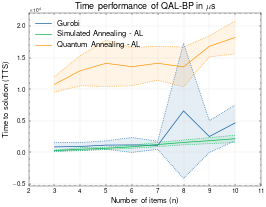

In [40]:
plot_runtime(df_mean_std_runtime)

Plotting the same results in log scale allows to observe also the runtime performance of the exact solver.

/content/utils.py:1159: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 10 ** 12)


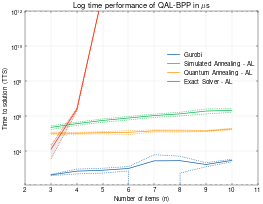

In [ ]:
plot_runtime_logscale(df_mean_std_runtime)

## Minimum eigenvalues distribution

Generate a bar plot to compare the energy of the best solutions found by Simulated, Quantum, and Exact solvers.


In [41]:
df_eigen_SA = df_final_SA[['instance_name','seed','AL_SA_min_eigenvalue']]
df_eigen_QA = df_final_QA['AL_QA_min_eigenvalue']
df_eigen = pd.concat([df_eigen_SA, df_eigen_QA], axis=1)
df_eigen.head()

,instance_name,seed,AL_SA_min_eigenvalue,AL_QA_min_eigenvalue
0,bpp_3_10,23,0.1334,0.1334
1,bpp_4_10,23,0.0059,0.0059
2,bpp_5_10,23,-0.0107,-0.0107
3,bpp_6_10,23,0.2115,0.3625
4,bpp_7_10,23,0.5376,1.0848


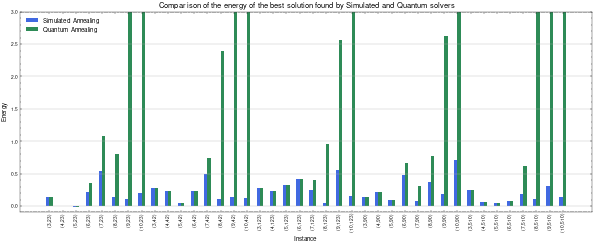

In [42]:
plot_eigenval(df_eigen)

## Feasibility density

What follows is a bar plot to visualize the probability of finding feasible solutions for different instance sizes.

In [43]:
df_feasible_density_SA = df_final_SA.groupby('instance_name', sort=False)['AL_SA_feasible'].apply(lambda x: (x==True).sum())/len(seeds)
df_feasible_density_QA = df_final_QA.groupby('instance_name', sort=False)['AL_QA_feasible'].apply(lambda x: (x==True).sum())/len(seeds)
df_feasible_density = pd.concat([df_feasible_density_SA, df_feasible_density_QA], axis=1)
df_feasible_density.head()

,AL_SA_feasible,AL_QA_feasible
instance_name,,
bpp_3_10,1.0,1.0
bpp_4_10,1.0,1.0
bpp_5_10,1.0,1.0
bpp_6_10,1.0,0.8
bpp_7_10,1.0,0.4


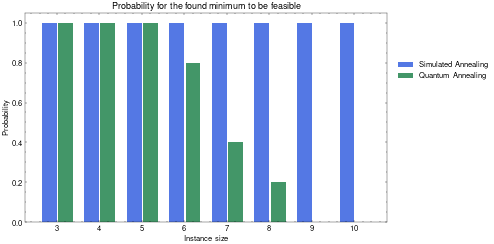

In [44]:
plot_feasibility_density(df_feasible_density)

## Runtime metrics

In [64]:
df_mean_std_runtime_metrics_QA = df_final_QA.groupby(['instance_name', 'n'], sort=False)[
       'AL_QA_runtime_metrics_qpu_sampling_time',
       'AL_QA_runtime_metrics_qpu_anneal_time_per_sample',
       'AL_QA_runtime_metrics_qpu_readout_time_per_sample',
       'AL_QA_runtime_metrics_qpu_access_time',
       'AL_QA_runtime_metrics_qpu_access_overhead_time',
       'AL_QA_runtime_metrics_qpu_programming_time',
       'AL_QA_runtime_metrics_qpu_delay_time_per_sample',
       'AL_QA_runtime_metrics_total_post_processing_time',
       'AL_QA_runtime_metrics_post_processing_overhead_time'].agg(['mean', 'std'])

df_mean_std_runtime_metrics_QA.columns = df_mean_std_runtime_metrics_QA.columns.map('_'.join)
df_mean_std_runtime_metrics_QA = df_mean_std_runtime_metrics_QA.reset_index()
display(df_mean_std_runtime_metrics_QA)

<ipython-input-64-9c5c8bf00763>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_mean_std_runtime_metrics_QA = df_final_QA.groupby(['instance_name', 'n'], sort=False)[


,instance_name,n,AL_QA_runtime_metrics_qpu_sampling_time_mean,AL_QA_runtime_metrics_qpu_sampling_time_std,AL_QA_runtime_metrics_qpu_anneal_time_per_sample_mean,AL_QA_runtime_metrics_qpu_anneal_time_per_sample_std,AL_QA_runtime_metrics_qpu_readout_time_per_sample_mean,AL_QA_runtime_metrics_qpu_readout_time_per_sample_std,AL_QA_runtime_metrics_qpu_access_time_mean,AL_QA_runtime_metrics_qpu_access_time_std,AL_QA_runtime_metrics_qpu_access_overhead_time_mean,AL_QA_runtime_metrics_qpu_access_overhead_time_std,AL_QA_runtime_metrics_qpu_programming_time_mean,AL_QA_runtime_metrics_qpu_programming_time_std,AL_QA_runtime_metrics_qpu_delay_time_per_sample_mean,AL_QA_runtime_metrics_qpu_delay_time_per_sample_std,AL_QA_runtime_metrics_total_post_processing_time_mean,AL_QA_runtime_metrics_total_post_processing_time_std,AL_QA_runtime_metrics_post_processing_overhead_time_mean,AL_QA_runtime_metrics_post_processing_overhead_time_std
0,bpp_3_10,3,10752.4,1228.311361,20.0,0.0,66.984,12.283114,26511.17,1228.174613,2228.23,581.203734,15758.77,0.282843,20.54,0.0,1078.4,769.703060,1078.4,769.703060
1,bpp_4_10,4,12906.4,2379.780410,20.0,0.0,88.524,23.797804,28665.33,2379.717472,1497.27,1001.517543,15758.93,0.456070,20.54,0.0,1285.6,849.613030,1285.6,849.613030
2,bpp_5_10,5,14088.4,3670.345597,20.0,0.0,100.344,36.703456,29847.49,3670.596109,1841.91,959.583249,15759.09,0.334664,20.54,0.0,1564.6,778.193935,1564.6,778.193935
3,bpp_6_10,6,13554.0,3011.709481,20.0,0.0,95.000,30.117095,29313.97,3011.664510,1651.63,880.795901,15759.97,1.232883,20.54,0.0,857.2,653.446019,857.2,653.446019
4,bpp_7_10,7,14093.2,2686.285018,20.0,0.0,100.392,26.862850,29852.93,2685.556547,1175.07,390.500535,15759.73,1.283745,20.54,0.0,1354.6,820.011768,1354.6,820.011768
5,bpp_8_10,8,13518.8,3144.638167,20.0,0.0,94.648,31.446382,29279.09,3143.908032,1208.91,444.953045,15760.29,0.867179,20.54,0.0,775.4,758.926413,775.4,758.926413
6,bpp_9_10,9,16772.0,1669.971257,20.0,0.0,127.180,16.699713,32533.09,1668.360450,1725.71,448.661712,15761.09,2.791415,20.54,0.0,1333.8,759.956380,1333.8,759.956380
7,bpp_10_10,10,18186.8,2597.528672,20.0,0.0,141.328,25.975287,33948.45,2596.752501,1805.15,416.139366,15761.65,1.453272,20.54,0.0,1025.2,666.218958,1025.2,666.218958


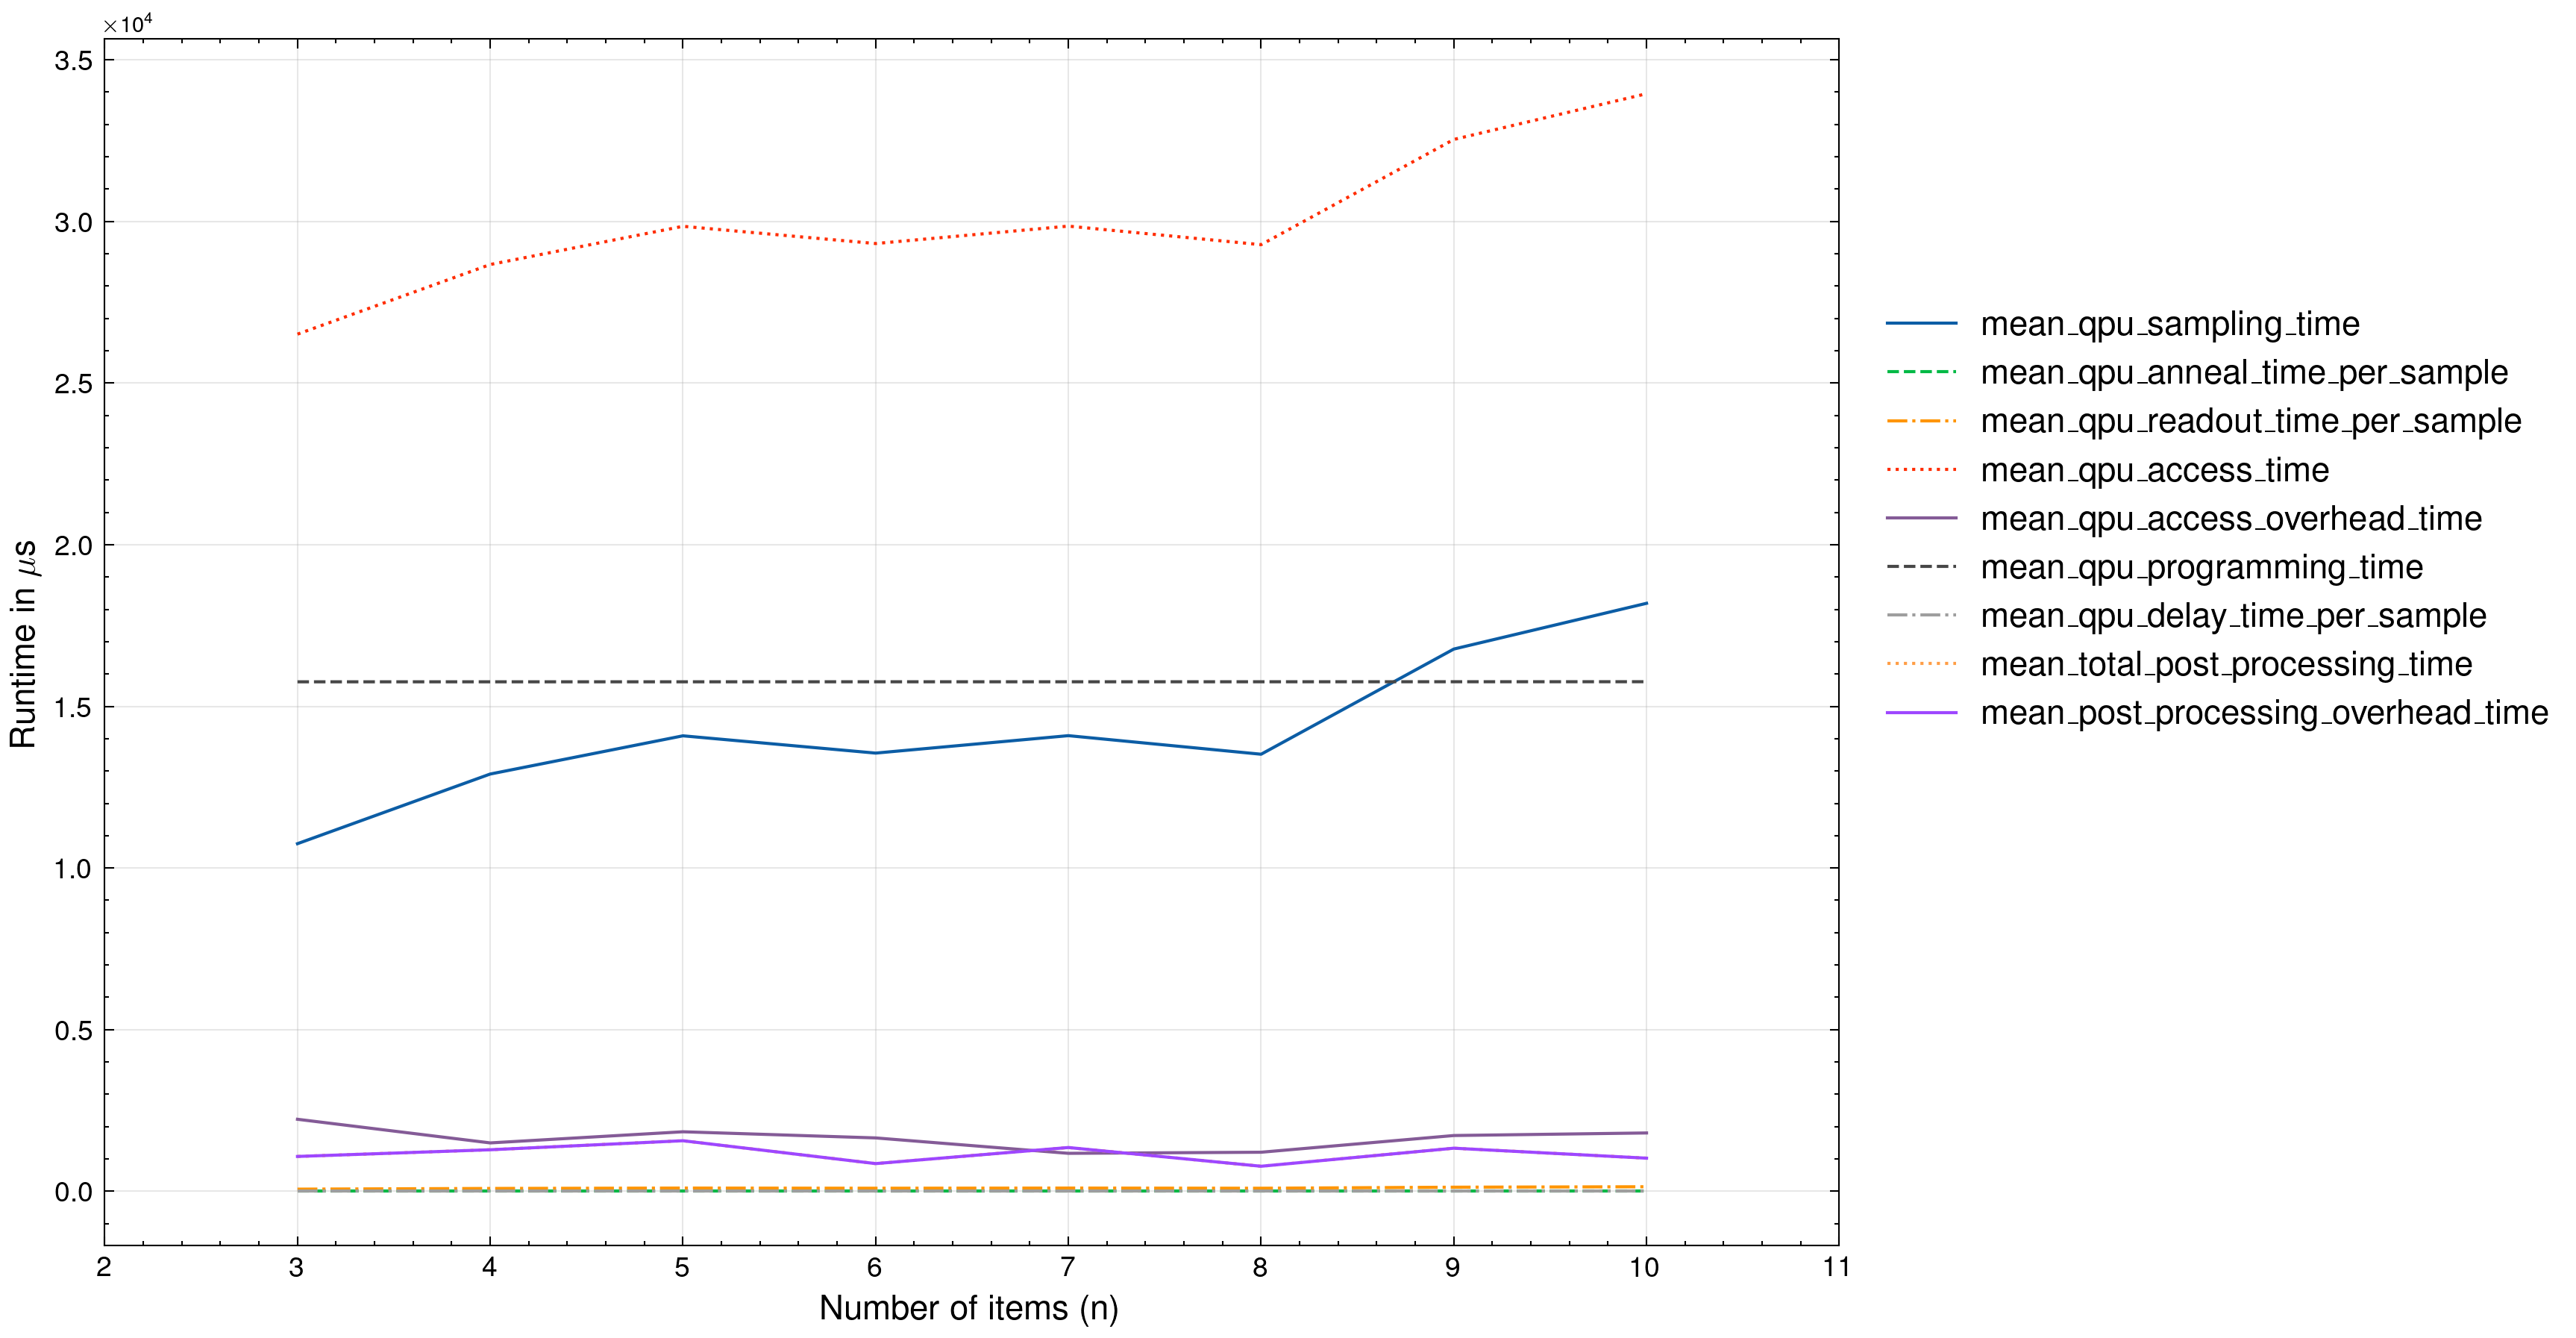

In [143]:
plot_all_runtime_metrics(df_mean_std_runtime_metrics_QA)

## Chain breaks analysis

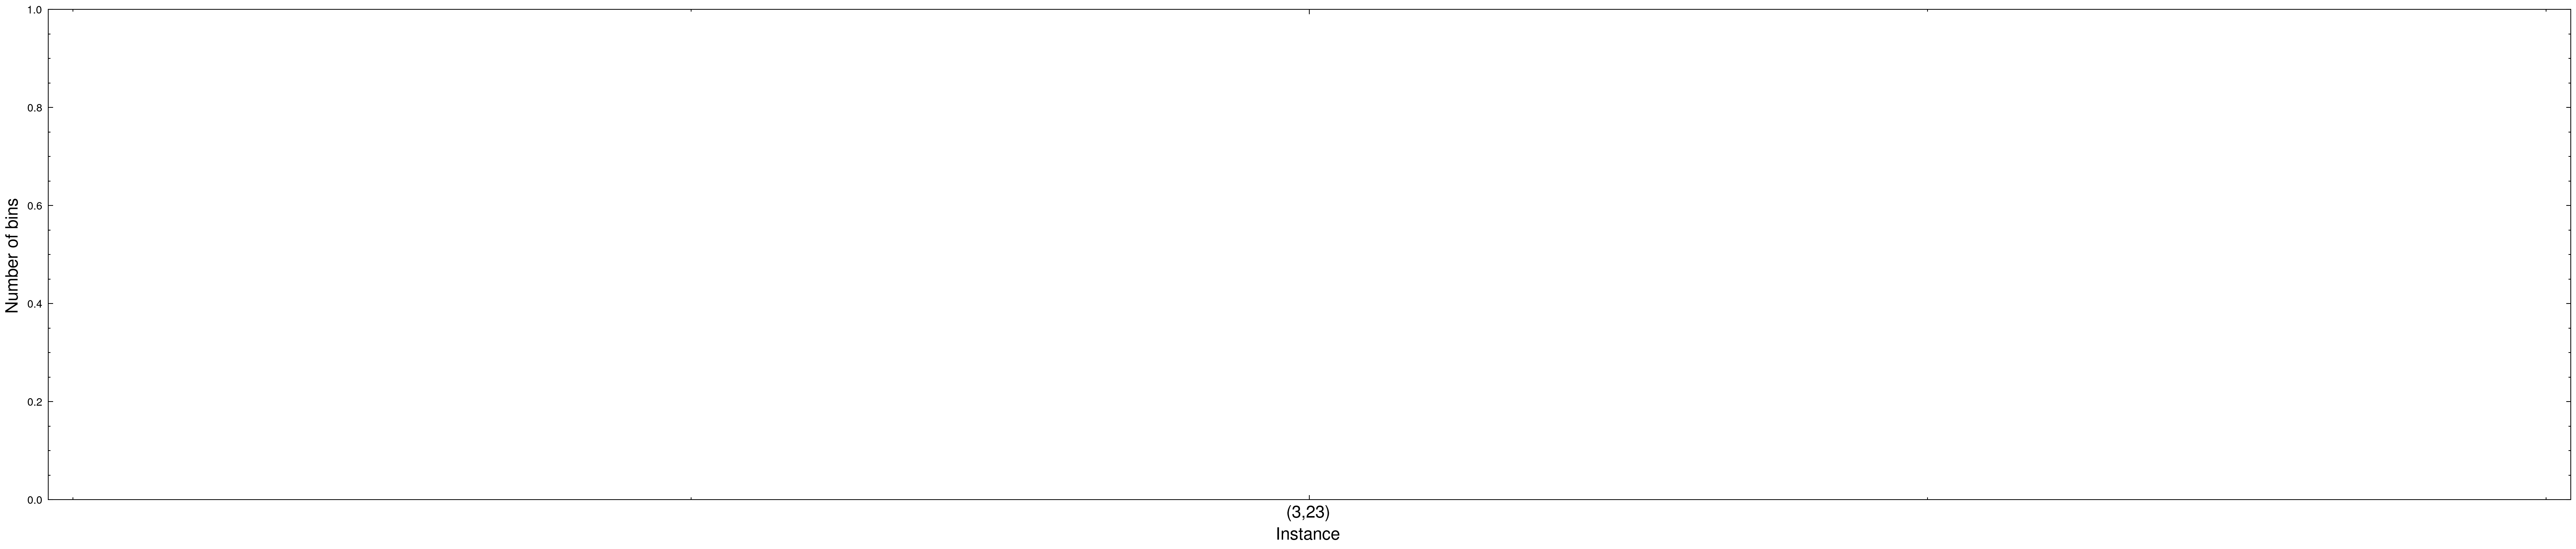

In [165]:
plot_chain_breaks(df_final_QA)

## Physical vs logical qubits

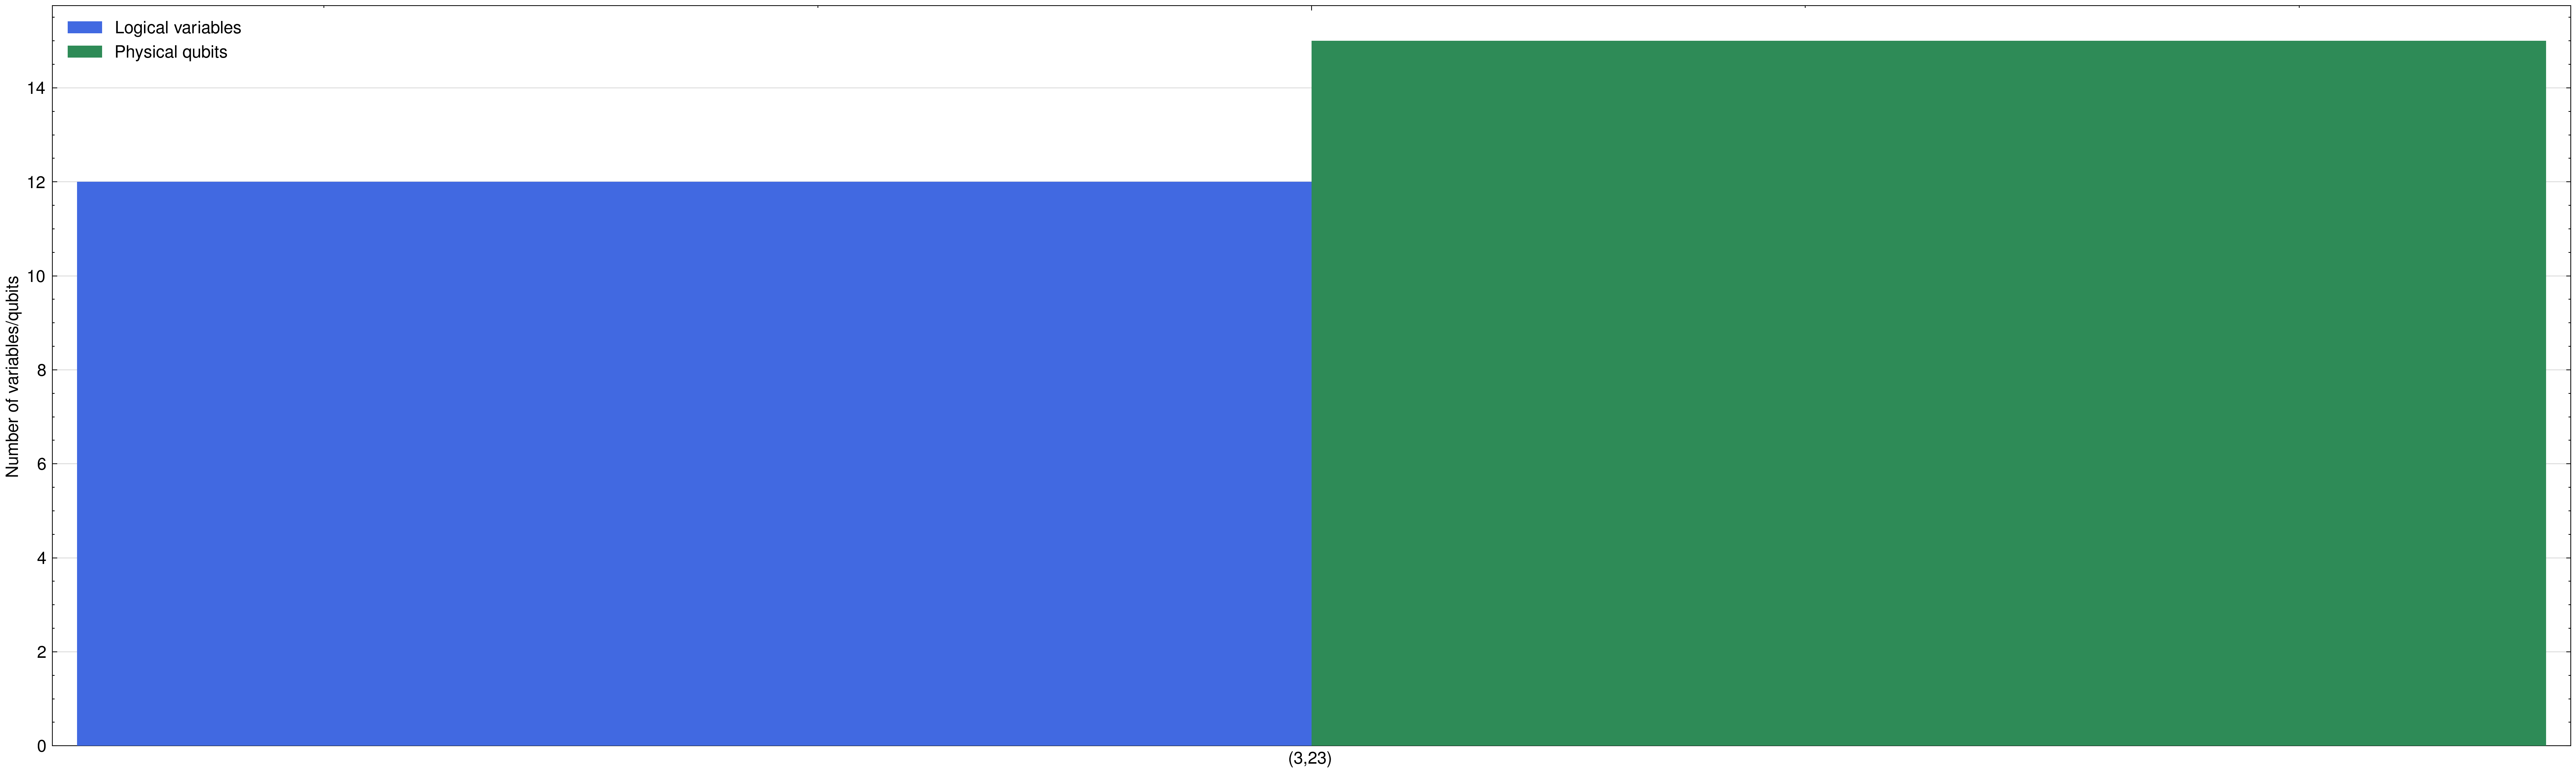

In [175]:
plot_phys_log_qubits(df_final_QA)